In [22]:
import math
th.pi = math.inf 

In [2]:
import os
import glob 
import numpy as np
import torch as th
from random import choices
import tqdm
import pickle
# save path 
save_path = r'F:\embedding_bhatt'
# specifiy the directory of data stored
data_path = r'F:\embedding_bhatt'
num_chkpoints = 2043

t_jialin = np.array([    0,     1,    63,   125,   187,   249,   251,   313,   375,
      437,   499,   501,   563,   625,   687,   749,   751,   813,
      875,   937,   999,  1001,  1063,  1125,  1187,  1249,  1500,
     1750,  2000,  2250,  2500,  2750,  3000,  3250,  3500,  3750,
     4000,  4250,  4500,  4750,  5000,  5250,  5500,  5750,  6000,
     6250,  6500,  7250,  8250,  9250, 10250, 11250, 12250, 13250,
    14250, 15250, 16250, 19000, 22750, 26500, 30250, 34000, 37750,
    41500, 45250, 49000, 50000])
t_save = set(list(np.arange(1000))+list(t_jialin) + list(np.arange(15000,35000,20)))
t_save = list(t_save)
t_save.sort()
 
jialin_ind = [np.where(t_save==k)[0][0] for k in t_jialin]

In [202]:
prog= pickle.load(open(os.path.join(save_path,'avg_model_progress.p'), 'rb')) 

# Progress Measure - Time, Average Loss, Projection to Geodesic

C:\Users\Deepika\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


Text(0, 0.5, 'Entropy Loss')

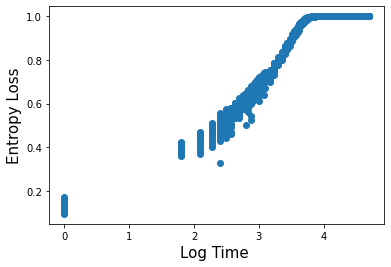

In [220]:
plt.scatter(np.log10(np.array(t_save)[list(jialin_ind)*30]),1-prog[:30,jialin_ind])
plt.xlabel('Log Time ',fontsize = 15)
plt.ylabel('Entropy Loss',fontsize = 15)

C:\Users\Deepika\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


Text(0, 0.5, 'Geodesic Projection \\Lambda')

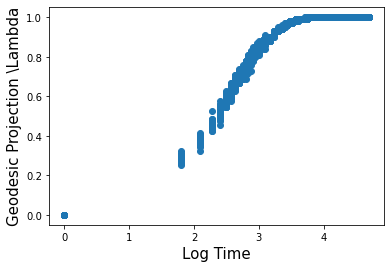

In [221]:
plt.scatter(np.log10(np.array(t_save)[list(jialin_ind)*30]),lam)
plt.xlabel('Log Time',fontsize = 15)
plt.ylabel('Geodesic Projection \Lambda',fontsize = 15)

Text(0.5, 0, 'Geodesic Projection \\Lambda')

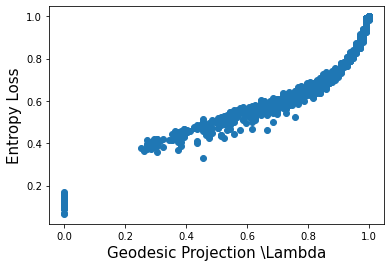

In [222]:
plt.scatter(lam,1-prog[:30,jialin_ind])
plt.ylabel('Entropy Loss',fontsize = 15)
plt.xlabel('Geodesic Projection \Lambda',fontsize = 15)

Helper functions 

In [27]:


def dbhat(x1, x2, reduction='mean', dev='cuda', debug=False, chunks=1000):
    "from jialin's repo"
    # x1, x2 shape (num_points, num_samples, num_classes)
    np1, ns, _ = x1.size()
    np2, ns, _ = x2.size()
    print(np1, np2, ns)
    x1, x2 = x1.transpose(0, 1), x2.transpose(0, 1)
    w = np.zeros([np1, np2])

    chunks = chunks or 1
    for aa in tqdm.tqdm(th.chunk(th.arange(ns), chunks)):
        xx1 = x1[aa, :].to(dev)
        xx2 = x2[aa, :].to(dev)
        aa = th.sqrt(aa)
        w_ = -th.log(th.bmm(th.sqrt(xx1), th.sqrt(xx2).transpose(1, 2)))
        w_[w_ > 1e12] = 100
        w_[w_ < 0] = 0
        w += w_.sum(0).cpu().numpy()
    if reduction == 'mean':
        return w / ns
    else:
        return w

def projection(Dbhatt):
    """
    From jialin's proj function
    """
    ne = 3 
    n = Dbhatt.shape[0]
    l = np.eye(Dbhatt.shape[0]) - 1.0/Dbhatt.shape[0]
    w = -l @ Dbhatt @ l / 2

    e1, v1 = sp.eigh(w, driver='evx', check_finite=False,
                     subset_by_index=[n-(ne+1), n-1])
    e2, v2 = sp.eigh(w , driver='evx', check_finite=False,
                     subset_by_index=[0, (ne+1)])
    e = np.concatenate((e1, e2))
    v = np.concatenate((v1, v2), axis=1)

    ii = np.argsort(np.abs(e))[::-1]
    e, v = e[ii], v[:, ii]
    xp = v*np.sqrt(np.abs(e))
    
    return xp, e, v

def new_points_in_embedding(new_points, p_list, dist_mat, eig_values, eig_vecs, distance = dbhat, embed_dimension =3):
    """
    From Itay's function 
    
    - slight modification for efficiency 
    
    """
    # using jialin's dbhatt/ diskl function 
    dp=distance(th.Tensor(new_points),th.Tensor(p_list),chunks= 20000)   
        
    d_mean=np.mean(dist_mat,0)
    d_mean_mean=np.mean(d_mean)
    dp_mean=dp-np.mean(dp)-d_mean+d_mean_mean
    dp_mean=-.5*dp_mean
    sqrtsigma=np.sqrt(np.abs(eig_values))
    
    return ((1/sqrtsigma)*np.matmul(dp_mean,eig_vecs))

In [6]:
# distance matrix for plotting
Dbhatt= pickle.load(open(os.path.join(save_path,'Dbhatt_jialin_chkpoints.p'), 'rb')) 
# p_list for plotting 
p_list= pickle.load(open(os.path.join(save_path,'p_list_jialin_chkpoints.p'), 'rb')) 


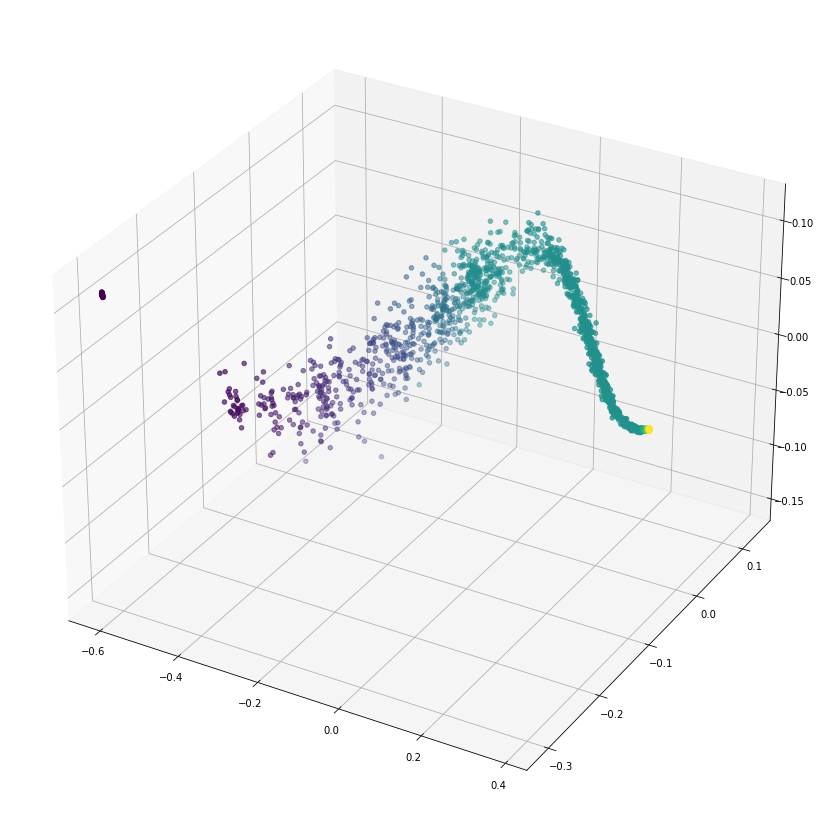

In [11]:
xp,e,v = projection(Dbhatt)

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xp[:,0],xp[:,1],xp[:,2],s=20,c=np.array(jialin_ind*30)/max(jialin_ind))


In [169]:
arithmetic_avg = np.zeros((67,50000,10))
geometric_avg= np.zeros((67,50000,10))
harmonic_avg= np.zeros((67,50000,10))
arithmetic_sqrt_avg= np.zeros((67,50000,10))
for n in tqdm.tqdm(range(67)):
    arithmetic_sqrt_avg[n,:,:]= ((np.sqrt(p_list[np.arange(30)*67+n,:,:])).mean(0))**2
    arithmetic_sqrt_avg[n,:,:]/=(arithmetic_sqrt_avg[n,:,:]).sum(1,keepdims=True)
    
    arithmetic_avg[n,:,:]= (p_list[np.arange(30)*67+n,:,:]).mean(0)
    arithmetic_avg[n,:,:]/=(arithmetic_avg[n,:,:]).sum(1,keepdims=True)
    
    geometric_avg[n,:,:]= np.exp(np.log(p_list[np.arange(30)*67+n,:,:]).mean(0))
    geometric_avg[n,:,:]/=(geometric_avg[n,:,:]).sum(1,keepdims=True)
    
    harmonic_avg[n,:,:]= ((p_list[np.arange(30)*67+n,:,:]**-1).mean(0))**-1
    harmonic_avg[n,:,:]/=harmonic_avg[n,:,:].sum(1,keepdims=True)

arithmetic_avg_traj = new_points_in_embedding(arithmetic_avg ,p_list,Dbhatt,e,v)
arithmetic_sqrt_avg_traj = new_points_in_embedding(arithmetic_sqrt_avg ,p_list,Dbhatt,e,v)
geometric_avg_traj = new_points_in_embedding(geometric_avg ,p_list,Dbhatt,e,v)
harmonic_avg_traj = new_points_in_embedding(harmonic_avg ,p_list,Dbhatt,e,v)


  0%|▏                                                                             | 37/16667 [00:00<00:45, 367.32it/s]

67 2010 50000


  0%|▎                                                                             | 65/16667 [00:00<00:25, 645.29it/s]

67 2010 50000


  0%|▎                                                                             | 58/16667 [00:00<00:28, 575.80it/s]

67 2010 50000


  0%|▎                                                                             | 63/16667 [00:00<00:26, 619.30it/s]

67 2010 50000


100%|███████████████████████████████████████████████████████████████████████████| 16667/16667 [00:26<00:00, 626.13it/s]


Text(0, 0.5, 'PC2')

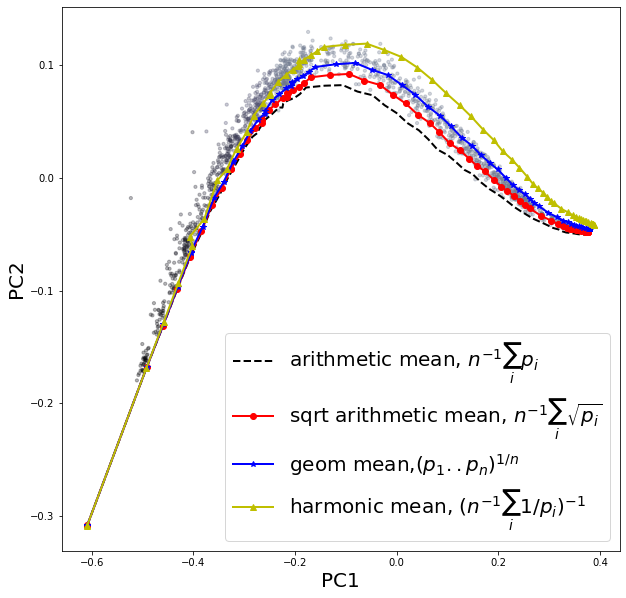

In [64]:
fig = plt.figure(figsize=(10,10))
plt.scatter(xp[:,0],xp[:,1],s=10,c=np.array(jialin_ind*30)/max(jialin_ind),cmap = 'bone', alpha = 0.3)
plt.plot(arithmetic_avg_traj[:,0],arithmetic_avg_traj[:,1],'k--',linewidth=2, label=r'arithmetic mean, $n^{-1}\sum_{i} {p_{i}}$')
plt.plot(arithmetic_sqrt_avg_traj[:,0],arithmetic_sqrt_avg_traj[:,1],'ro-',linewidth=2, label=r'sqrt arithmetic mean, $n^{-1}\sum_{i} \sqrt{p_{i}}$')
plt.plot(geometric_avg_traj[:,0],geometric_avg_traj[:,1],'b*-',linewidth=2, label= r'geom mean,$ (p_{1}..p_{n})^{1/n}$')
plt.plot(harmonic_avg_traj[:,0],harmonic_avg_traj[:,1],'y^-',linewidth=2, label= r'harmonic mean, $ (n^{-1}\sum_{i} 1/{p_{i}})^{-1}$')
plt.legend(fontsize=20)
plt.xlabel('PC1',fontsize=20)
plt.ylabel('PC2',fontsize=20)


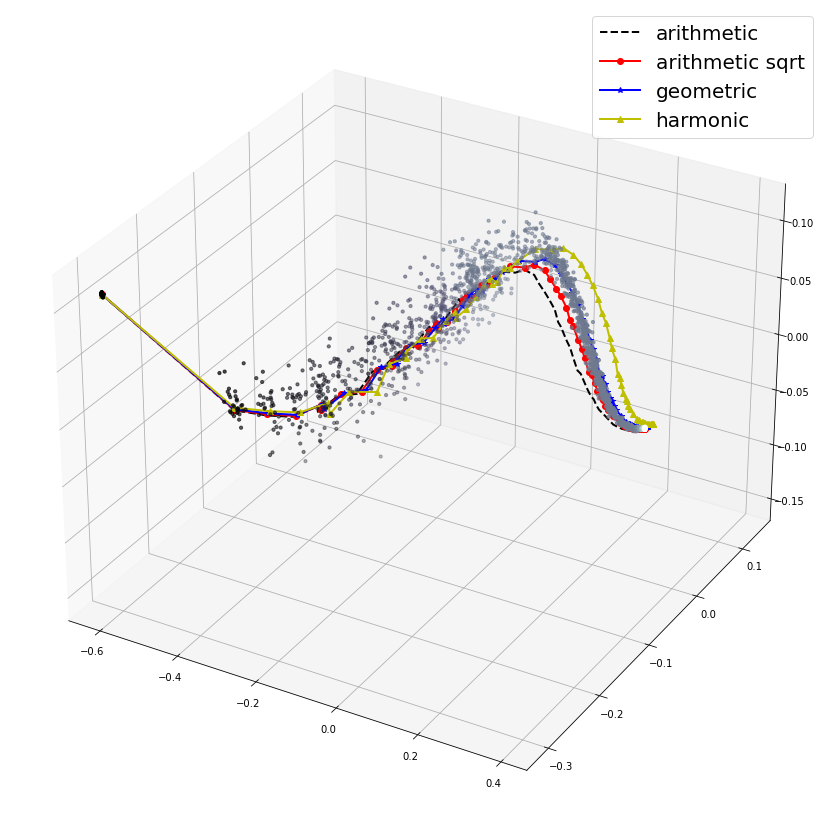

In [57]:
%matplotlib inline
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xp[:,0],xp[:,1],xp[:,2],s=10,c=np.array(jialin_ind*30)/max(jialin_ind),cmap = 'bone')
ax.plot(arithmetic_avg_traj[:,0],arithmetic_avg_traj[:,1],arithmetic_avg_traj[:,2],'k--',linewidth=2, label='arithmetic')
ax.plot(arithmetic_sqrt_avg_traj[:,0],arithmetic_sqrt_avg_traj[:,1],arithmetic_sqrt_avg_traj[:,2],'ro-',linewidth=2, label='arithmetic sqrt')
ax.plot(geometric_avg_traj[:,0],geometric_avg_traj[:,1],geometric_avg_traj[:,2],'b*-',linewidth=2, label='geometric')
ax.plot(harmonic_avg_traj[:,0],harmonic_avg_traj[:,1],harmonic_avg_traj[:,2],'y^-',linewidth=2, label='harmonic')
ax.legend(fontsize=20)

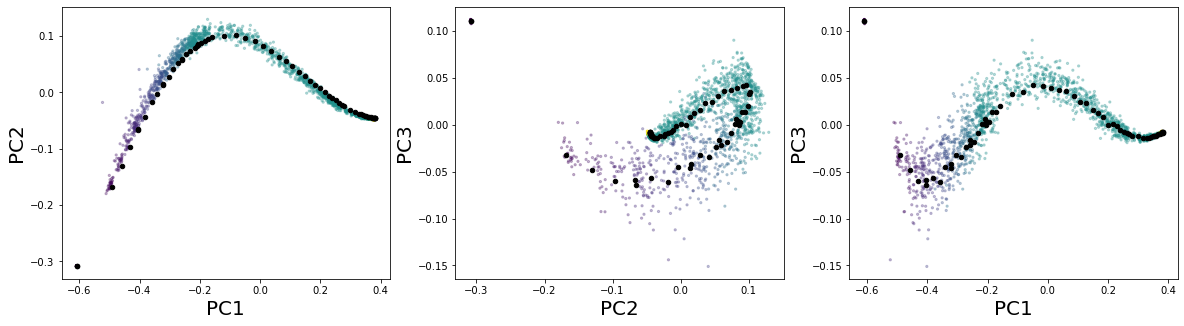

In [65]:
plt.figure(figsize=(20,5))
for i in range(3):
    plt.subplot(1,3,i+1)
    if i<2:
        plt.scatter(xp[:,i],xp[:,i+1],s=5,alpha = 0.3,c=np.array(jialin_ind*30)/max(jialin_ind))
        plt.scatter(geometric_avg_traj[:,i],geometric_avg_traj[:,i+1],c='k',s=20)
        plt.xlabel('PC'+str(i+1),fontsize=20)
        plt.ylabel('PC'+str(i+2),fontsize=20)
    if i==2:
        plt.scatter(xp[:,0],xp[:,2],s=5,alpha = 0.3,c=np.array(jialin_ind*30)/max(jialin_ind))
        plt.scatter(geometric_avg_traj[:,0],geometric_avg_traj[:,2],c='k',s=20)      
        plt.xlabel('PC1',fontsize=20)
        plt.ylabel('PC3',fontsize=20)

# Averaging based on progress, projection to geodesic 

In [69]:
def projection(r, p, q, debug=False, mode='prod'):
    # r, p, q shape (nmodels, nsamples, nclasses)
    if debug:
        assert np.allclose([(r**2).sum(-1), (p**2).sum(-1), (q**2).sum(-1)], 1)
    cost, cost1, cost2 = (p*q).sum(-1, keepdims=True), (p*r).sum(-1, keepdims=True), (q*r).sum(-1, keepdims=True)
    if mode == 'prod':
        ti = np.arccos(cost)
        d = lambda t: np.arccos(cost1*np.sin((1-t)*ti)/np.sin(ti) + cost2* np.sin(t*ti)/np.sin(ti)).sum(1)
        d0 = d(0)
        lams = np.linspace(0, 1, 100)
        lam = np.zeros([ti.shape[0], 1])
        res = map(d, lams)
        for (i, dt) in tqdm.tqdm(enumerate(res)):
            lam[dt < d0] = lams[i]
            d0 = dt
    elif mode == 'mean':
        tan = cost2/(cost1*np.sqrt(1-cost**2)) - cost / np.sqrt(1-cost**2)
        lam = (np.arctan(tan) * (tan > 0)) / np.arccos(cost)
        lam[lam > 1] = 1
    return lam


def gamma(t, p, q):
    # p, q shape: nmodels, nsamples, nclasses
    cospq = (p*q).sum(-1)
    if cospq.max() > 1 or cospq.min() < 0: 
        cospq[cospq > 1] = 1
        cospq[cospq < 0] = 0
    ti = np.arccos(cospq)
    mask = ti==0
    gamma = np.zeros_like(p)
    gamma[mask, :] = p[mask, :]
    p, q = p[~mask, :], q[~mask, :]
    ti = ti[~mask, None]
    gamma[~mask, :] = np.sin((1-t)*ti) / np.sin(ti) * \
        p + np.sin(t*ti) / np.sin(ti) * q
    return gamma


In [166]:
progress_ = np.linspace(0.25,.95,20)
for i in range(20):
    print(len(np.where(abs(lam-progress_[i])<1e-2)[0]))

1
11
2
6
11
6
13
20
18
10
15
21
33
28
30
48
82
61
24
59


In [167]:
arithmetic_avg_lam = np.zeros((20,50000,10))
geometric_avg_lam= np.zeros((20,50000,10))
harmonic_avg_lam= np.zeros((20,50000,10))
arithmetic_sqrt_avg_lam= np.zeros((20,50000,10))
for n in tqdm.tqdm(range(20)):
    selected = np.where(abs(lam-progress_[n])<1e-2)[0]
    arithmetic_sqrt_avg_lam[n,:,:]= ((np.sqrt(p_list[selected,:,:])).mean(0))**2
    arithmetic_sqrt_avg_lam[n,:,:]/=(arithmetic_sqrt_avg_lam[n,:,:]).sum(1,keepdims=True)
    
    arithmetic_avg_lam[n,:,:]= (p_list[selected,:,:]).mean(0)
    arithmetic_avg_lam[n,:,:]/=(arithmetic_avg_lam[n,:,:]).sum(1,keepdims=True)
    
    geometric_avg_lam[n,:,:]= np.exp(np.log(p_list[selected,:,:]).mean(0))
    geometric_avg_lam[n,:,:]/=(geometric_avg_lam[n,:,:]).sum(1,keepdims=True)
    
    harmonic_avg_lam[n,:,:]= ((p_list[selected,:,:]**-1).mean(0))**-1
    harmonic_avg_lam[n,:,:]/=harmonic_avg_lam[n,:,:].sum(1,keepdims=True)

arithmetic_avg_traj_lam = new_points_in_embedding(arithmetic_avg_lam ,p_list,Dbhatt,e,v)
arithmetic_sqrt_avg_traj_lam = new_points_in_embedding(arithmetic_sqrt_avg_lam ,p_list,Dbhatt,e,v)
geometric_avg_traj_lam = new_points_in_embedding(geometric_avg_lam ,p_list,Dbhatt,e,v)
harmonic_avg_traj_lam = new_points_in_embedding(harmonic_avg_lam ,p_list,Dbhatt,e,v)


  0%|▎                                                                             | 66/16667 [00:00<00:25, 655.21it/s]

20 2010 50000


  0%|                                                                                        | 0/16667 [00:00<?, ?it/s]

20 2010 50000


  0%|▎                                                                             | 64/16667 [00:00<00:25, 639.41it/s]

20 2010 50000


  0%|▎                                                                             | 73/16667 [00:00<00:22, 724.78it/s]

20 2010 50000


100%|███████████████████████████████████████████████████████████████████████████| 16667/16667 [00:22<00:00, 735.28it/s]


Text(0, 0.5, 'PC2')

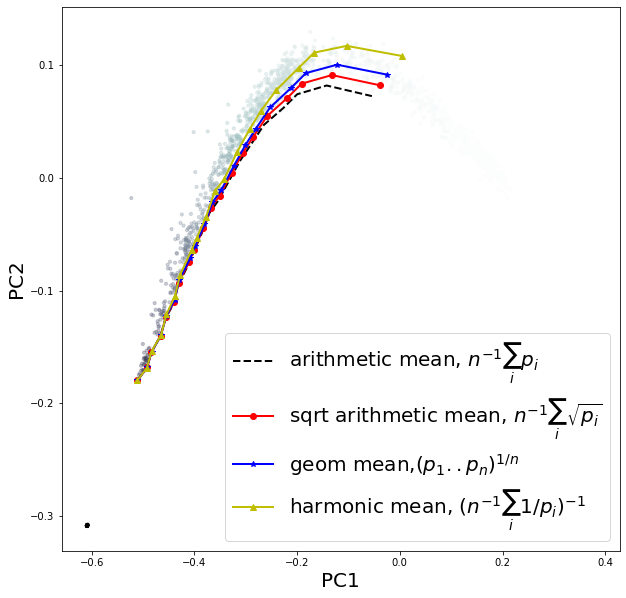

In [168]:
fig = plt.figure(figsize=(10,10))
plt.scatter(xp[:,0],xp[:,1],s=10,c=lam,cmap = 'bone', alpha = 0.3)
plt.plot(arithmetic_avg_traj_lam[:,0],arithmetic_avg_traj_lam[:,1],'k--',linewidth=2, label=r'arithmetic mean, $n^{-1}\sum_{i} {p_{i}}$')
plt.plot(arithmetic_sqrt_avg_traj_lam[:,0],arithmetic_sqrt_avg_traj_lam[:,1],'ro-',linewidth=2, label=r'sqrt arithmetic mean, $n^{-1}\sum_{i} \sqrt{p_{i}}$')
plt.plot(geometric_avg_traj_lam[:,0],geometric_avg_traj_lam[:,1],'b*-',linewidth=2, label= r'geom mean,$ (p_{1}..p_{n})^{1/n}$')
plt.plot(harmonic_avg_traj_lam[:,0],harmonic_avg_traj_lam[:,1],'y^-',linewidth=2, label= r'harmonic mean, $ (n^{-1}\sum_{i} 1/{p_{i}})^{-1}$')
plt.legend(fontsize=20)
plt.xlabel('PC1',fontsize=20)
plt.ylabel('PC2',fontsize=20)


Text(0, 0.5, 'PC2')

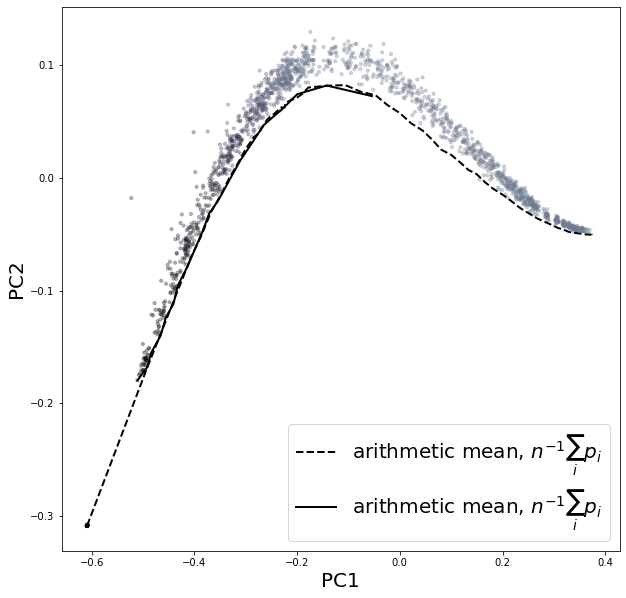

In [174]:
fig = plt.figure(figsize=(10,10))
plt.scatter(xp[:,0],xp[:,1],s=10,c=np.array(jialin_ind*30)/max(jialin_ind),cmap = 'bone', alpha = 0.3)
plt.plot(arithmetic_avg_traj[:,0],arithmetic_avg_traj[:,1],'k--',linewidth=2, label=r'arithmetic mean, $n^{-1}\sum_{i} {p_{i}}$')
plt.plot(arithmetic_avg_traj_lam[:,0],arithmetic_avg_traj_lam[:,1],'k',linewidth=2, label=r'arithmetic mean, $n^{-1}\sum_{i} {p_{i}}$')
plt.legend(fontsize=20)
plt.xlabel('PC1',fontsize=20)
plt.ylabel('PC2',fontsize=20)


Text(0, 0.5, 'PC2')

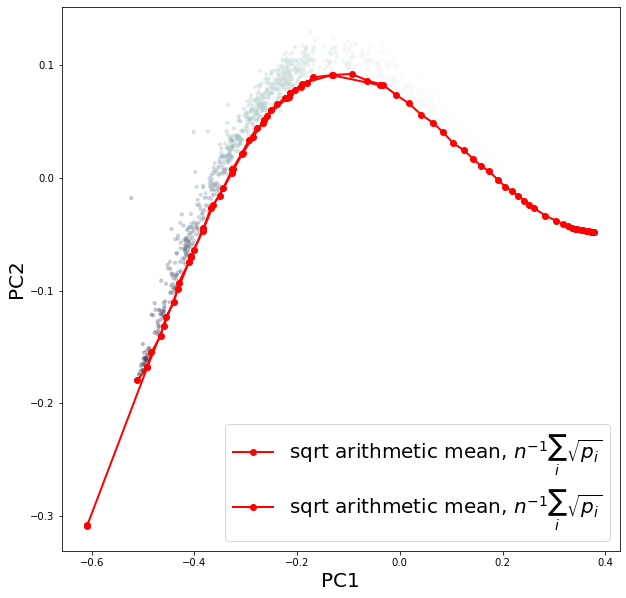

In [175]:
fig = plt.figure(figsize=(10,10))
plt.scatter(xp[:,0],xp[:,1],s=10,c=lam,cmap = 'bone', alpha = 0.3)
plt.plot(arithmetic_sqrt_avg_traj[:,0],arithmetic_sqrt_avg_traj[:,1],'ro-',linewidth=2, label=r'sqrt arithmetic mean, $n^{-1}\sum_{i} \sqrt{p_{i}}$')
plt.plot(arithmetic_sqrt_avg_traj_lam[:,0],arithmetic_sqrt_avg_traj_lam[:,1],'ro-',linewidth=2, label=r'sqrt arithmetic mean, $n^{-1}\sum_{i} \sqrt{p_{i}}$')

plt.legend(fontsize=20)
plt.xlabel('PC1',fontsize=20)
plt.ylabel('PC2',fontsize=20)


Text(0, 0.5, 'PC2')

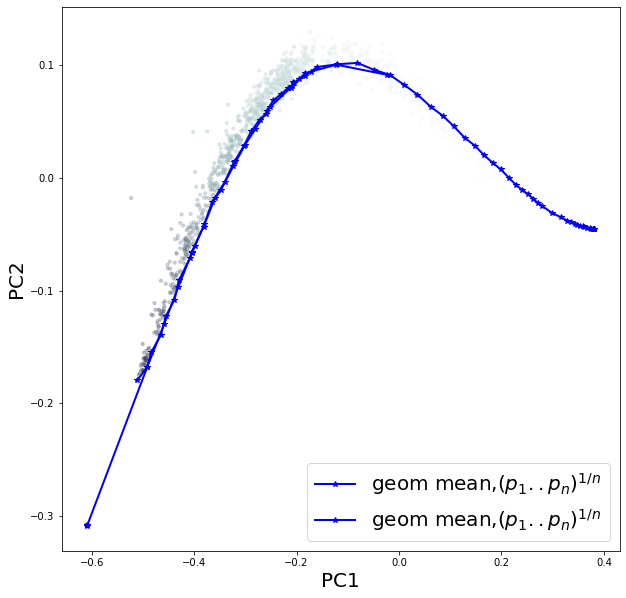

In [176]:
fig = plt.figure(figsize=(10,10))
plt.scatter(xp[:,0],xp[:,1],s=10,c=lam,cmap = 'bone', alpha = 0.3)

plt.plot(geometric_avg_traj[:,0],geometric_avg_traj[:,1],'b*-',linewidth=2, label= r'geom mean,$ (p_{1}..p_{n})^{1/n}$')
plt.plot(geometric_avg_traj_lam[:,0],geometric_avg_traj_lam[:,1],'b*-',linewidth=2, label= r'geom mean,$ (p_{1}..p_{n})^{1/n}$')


plt.legend(fontsize=20)
plt.xlabel('PC1',fontsize=20)
plt.ylabel('PC2',fontsize=20)


Text(0, 0.5, 'PC2')

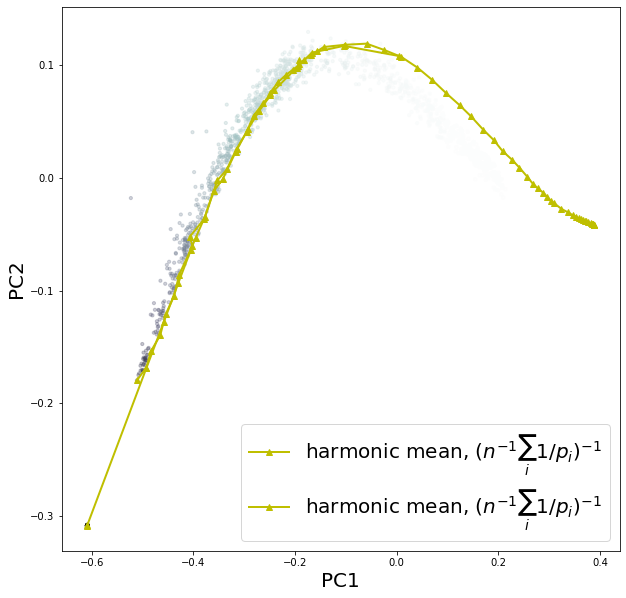

In [177]:
fig = plt.figure(figsize=(10,10))
plt.scatter(xp[:,0],xp[:,1],s=10,c=lam,cmap = 'bone', alpha = 0.3)

plt.plot(harmonic_avg_traj[:,0],harmonic_avg_traj[:,1],'y^-',linewidth=2, label= r'harmonic mean, $ (n^{-1}\sum_{i} 1/{p_{i}})^{-1}$')
plt.plot(harmonic_avg_traj_lam[:,0],harmonic_avg_traj_lam[:,1],'y^-',linewidth=2, label= r'harmonic mean, $ (n^{-1}\sum_{i} 1/{p_{i}})^{-1}$')


plt.legend(fontsize=20)
plt.xlabel('PC1',fontsize=20)
plt.ylabel('PC2',fontsize=20)



# Bhattacharyya centroid - debugging

In [192]:
def theta(p):
    # converts to natural param
    # assume p is of the frm n_model x n_image x n_class
    theta_ = np.log(p/(10**-5+1-p[:,:,:-1].sum(2,keepdims=True)))
    return theta_

def F(theta):
    # log partition function for categorial distribution
    return np.log(1+np.exp(theta[:,:,:-1]).sum(2,keepdims = True))

def nablaF(theta):
    # Gradient of log partition function for categorial distribution
    return np.exp(theta[:,:,:-1])/(1+np.exp(theta[:,:,:-1]).sum(2,keepdims = True))

def nablaF_inv(eta):
    # reciprocal of the gradient of log partition function for categorial distribution
    return np.log(eta/(1-eta.sum(2,keepdims = True)+1e-8))

def g_mean(p):
    # geometric mean as the initial point of guess 
    gm = np.exp(np.log(p).mean(0,keepdims=True))
    return gm/gm.sum(1,keepdims=True)

def Bhat_centroid(p):
    """
    Based on 
    Nielsen, Frank, and Sylvain Boltz. "The burbea-rao and bhattacharyya centroids." IEEE Transactions on Information Theory 57.8 (2011): 5455-5466.
    https://arxiv.org/abs/1004.5049
    
    -- utilizes iterative concave-convex optimization algorithm

    """
    # initialization
    c = p.mean(0,keepdims=True)
    #Concave Convex opt
    err1=[]
    err2=[]
    
    for _ in range(10):
        
        c_t= nablaF_inv(nablaF(theta(0.5*p+0.5*c)).mean(0,keepdims=True))
        c_t = np.exp(c_t)/(1+np.exp(c_t).sum(2,keepdims=True))
        c_t = th.cat((c_t,1-c_t.sum(2,keepdims=True)),2)
        err1.append(dbhat(c_t,p))
        err2.append(dbhat(g_mean(p).reshape((1,50000,10)),p))
        c=c_t
    return c_t

In [196]:
bhatt_centroid = np.zeros((67,50000,10))
for n in tqdm.tqdm(range(67)):

    bhatt_centroid[n,:,:]= arithmetic_avg[n,:,:]+geometric_avg[n,:,:]
    bhatt_centroid[n,:,:]/=bhatt_centroid[n,:,:].sum(1,keepdims=True)



100%|█████████████████████████████████████████████████████████████████████████████████| 67/67 [00:00<00:00, 232.51it/s]


In [197]:
bhatt_centroid_traj = new_points_in_embedding(bhatt_centroid ,p_list,Dbhatt,e,v)

  0%|▏                                                                             | 42/16667 [00:00<00:40, 412.87it/s]

67 2010 50000


100%|███████████████████████████████████████████████████████████████████████████| 16667/16667 [00:26<00:00, 638.26it/s]


Text(0, 0.5, 'PC2')

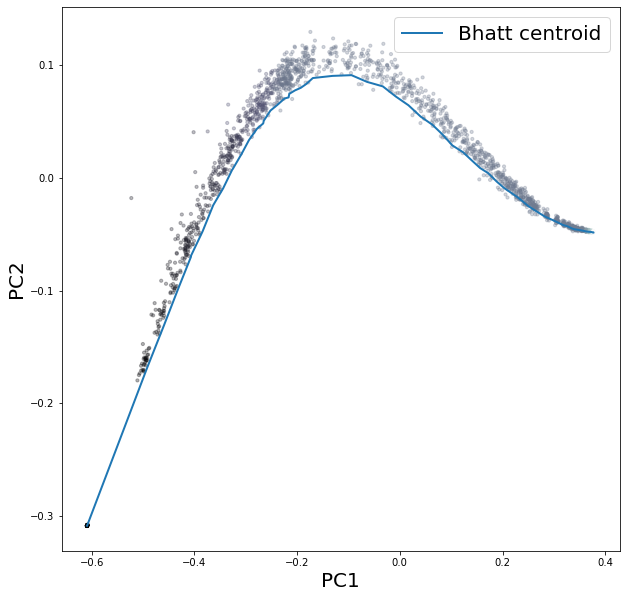

In [201]:
fig = plt.figure(figsize=(10,10))
plt.scatter(xp[:,0],xp[:,1],s=10,c=np.array(jialin_ind*30)/max(jialin_ind),cmap = 'bone', alpha = 0.3)
#plt.plot(arithmetic_avg_traj[:,0],arithmetic_avg_traj[:,1],'k--',linewidth=2, label=r'arithmetic mean, $n^{-1}\sum_{i} {p_{i}}$')
#plt.plot(arithmetic_sqrt_avg_traj[:,0],arithmetic_sqrt_avg_traj[:,1],'ro-',linewidth=2, label=r'sqrt arithmetic mean, $n^{-1}\sum_{i} \sqrt{p_{i}}$')
#plt.plot(geometric_avg_traj[:,0],geometric_avg_traj[:,1],'b*-',linewidth=2, label= r'geom mean,$ (p_{1}..p_{n})^{1/n}$')
#plt.plot(harmonic_avg_traj[:,0],harmonic_avg_traj[:,1],'y^-',linewidth=2, label= r'harmonic mean, $ (n^{-1}\sum_{i} 1/{p_{i}})^{-1}$')
plt.plot(bhatt_centroid_traj[:,0],bhatt_centroid_traj[:,1],linewidth=2,label = r'Bhatt centroid')
plt.legend(fontsize=20)
plt.xlabel('PC1',fontsize=20)
plt.ylabel('PC2',fontsize=20)
